In [1]:
import rsmine.coarsegrainer.cg_optimisers as cg_opt
from rsmine.coarsegrainer.cg_utils import *
from rsmine.coarsegrainer.analysis_utils import *
sys.path.append(os.pardir)
from rsmine.mi_estimator.MI_estimators import VBMI

from examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data
from analyse_codes import *
import pickle

examples_dir = '.'
regions_data_dir = examples_dir + '/quasiperiodic_data/regions/'


/Users/efe/Documents/Research/RSMI-NE/rsmine/coarsegrainer/build_dataset.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


cm = 1/2.54 # convert inches to centimeters
fontsize = 7

plt.rc('text', usetex=False)  # True
params = {
    #'text.latex.preamble': r'\usepackage{tgheros}'    # helvetica font
    #                   + r'\usepackage{sansmath}'   # math-font matching  helvetica
    #                   + r'\sansmath'                # actually tell tex to use it!
    #                   + r'\usepackage{siunitx}'    # micro symbols
    #                   + r'\sisetup{detect-all}',    # force siunitx to use the fonts
    'axes.grid': False,
    'savefig.dpi': 400,  # to adjust notebook inline plot size
    'axes.labelsize': fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize': fontsize,
    'font.size': fontsize,
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'text.usetex': False,
    'font.family': 'Arial',
    'figure.facecolor': 'white',
}
mpl.rcParams.update(params)


In [3]:
def small_V_visualize(V_edgelist, edge_densities, edges=None, nodes=None, nodepos=None,
                      n_rows=1, n_cols=1, title="", figsize=(10.4, 6.8), node_size=1, width=3, cmap='bwr',
                      layout_dict={"pad": 0.0, "h_pad": 0.08,
                                   "w_pad": -10.08, "rect": (0, 0, 1, 1)},
                      label_dict=None, edge_vmin=None, edge_vmax=None, savename=None, fontsize=3):
    """
    Plot multicomponent data (filters,PCA components,....) on the V subgraph  (doesn't draw the full system).
    Ensure that number of subplots is equal to the number of data components.
    V_edgelist -- list of edge IDs in V
    edge_densities -- mutlicomponent data to be plotted on V
    """
    # ----- Prepare data, graph, .... --------------
    R = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
              'colors': edge_densities[num, :]}) for num, e_ind in enumerate(V_edgelist)]
    R.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
             for i in range(num_vtx)}
    nx.set_node_attributes(R, ndict)

    ecolors = [R[u][v]['colors'] for u, v in R.edges()]
    pos_V = nx.get_node_attributes(R, 'pos')

    # ----- Plot subfigures ---------------
    layout_dict = layout_dict
    n_rows = n_rows
    n_cols = n_cols
    if n_rows*n_cols != edge_densities.shape[-1]:
        print("WARNING: num of sublots and components do not match: ",
              n_rows*n_cols, edge_densities.shape[-1])

    fig = plt.figure(tight_layout=layout_dict, figsize=figsize)  # figure(1,)
    axes_plots = []

    for plot_ind in range(1, n_rows*n_cols+1):
        try:
            axes_plots.append(plt.subplot(n_rows, n_cols, plot_ind))
            plt.gca().set_aspect('equal')
            #plt.gca().set_title(title+str(plot_ind))
            nx.draw(R, pos_V, node_color='black',
                    node_size=node_size,
                    edge_color=np.array(ecolors)[:, plot_ind-1],
                    edge_cmap=plt.get_cmap(cmap),
                    width=width, edge_vmin=edge_vmin, edge_vmax=edge_vmax)

            if label_dict is not None:
                nx.draw_networkx_edge_labels(G, pos_V, edge_labels=label_dict, font_size=fontsize)

        except IndexError:
            print("No data components for subplot", plot_ind)

    if savename:
        plt.savefig(savename, bbox_inches='tight')
        plt.close()

    return R


In [4]:
def rotate_edges(original_edges, angle, nodepos, edges, target_vertex=389):

    rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_nodepos = np.matmul(
        nodepos - nodepos[target_vertex], rot) + nodepos[target_vertex]

    tt_coords = np.array([[nodepos[int(edges[edge][0])],
                           nodepos[int(edges[edge][1])]] for edge in original_edges])
    tt_coords_lexsort_inside_edge = [
        edge[np.lexsort(np.rot90(edge))] for edge in tt_coords]


    trsl_coords = np.array([[rotated_nodepos[int(edges[edge][0])],
                            rotated_nodepos[int(edges[edge][1])]] for edge in original_edges])
    trsl_coords_lexsort_inside_edge = [
        edge[np.lexsort(np.rot90(edge))] for edge in trsl_coords]


    subarr_pos=[]
    for j,subarr in enumerate(trsl_coords_lexsort_inside_edge):

        t = 0
        for i,subarr2 in enumerate(tt_coords_lexsort_inside_edge):
            if np.all(np.isclose(subarr, subarr2, atol=1e-05)) or np.all(np.isclose(subarr, [subarr2[1], subarr2[0]], atol=1e-07)):
                subarr_pos+=[i]

                t += 1

        if t == 0:
            print(subarr)

    return subarr_pos
        

In [5]:
coarse_grainers = {
                    'sigma2': {
                        '8': {389: None},
                        '3': {
                            404: None,
                            399: None,
                            3742: None,
                            7010: None,
                            10286: None,
                            13554: None,
                            16830: None,
                            20098: None
                        },
                    },
                    'sigma4': {
                        '8': {389: None},
                        '3': {
                            196: None,
                            274: None
                        },
                    }
                }

## Load pre-trained coarse-grainers

Run the following cell to load the pre-trained coarse-grainers.

In [7]:
with open('paper_data/sigma2_coarsegrainers.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(b)

coarse_grainers = b


{'sigma2': {'8': {389: array([[ 9.5985448e-01,  8.9009720e-01, -8.9365798e-01,  2.5170854e-01],
       [-1.2315978e+00,  1.6887152e+00,  4.5657003e-01, -1.6812177e+00],
       [ 9.9630547e-01, -9.5967269e-01, -2.9891673e-01,  9.9298185e-01],
       [-1.3803282e+00, -1.7091414e+00,  1.6938057e+00,  1.6428331e-01],
       [ 1.1317390e-02,  1.3779151e+00, -9.2866158e-01, -1.0129631e+00],
       [-2.7623983e-02, -1.3846128e+00,  8.5658318e-01,  1.0041704e+00],
       [ 1.1614647e-02, -1.3384666e+00,  8.6834842e-01,  9.0378016e-01],
       [ 2.8790426e-03,  1.3506365e+00, -7.8544253e-01, -8.5758418e-01],
       [ 1.0149660e+00, -1.4719964e+00, -2.4318410e-02,  1.6151508e+00],
       [ 1.0722574e+00,  1.5853426e+00, -1.5354627e+00, -1.1834076e-01],
       [ 9.9049681e-01, -3.0850992e-01, -9.8241717e-01,  9.6800607e-01],
       [ 3.0126318e-01, -1.0095576e+00,  8.2897967e-01,  1.0184883e+00],
       [-1.6302452e+00,  1.3573998e-02,  1.7040411e+00, -1.3508564e+00],
       [-1.1406892e-01,  1.6

# Prepare and load the dataset

In [8]:
case_dict = {'sigma2': {'8': {'case_no': 49, 'V_index': 389},
                        '3': {'case_no': 50, 'V_index': 16830}}, 
            'sigma4': {'8': {'case_no': None, 'V_index': 389},
                        '3': {'case_no': None, 'V_index': None}}}


In [9]:
freqs_filtered_all = {}


In [10]:
"""
import sys, importlib
importlib.reload(sys.modules['examples.AB_prepare_dataset'])
from examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data
"""

"\nimport sys, importlib\nimportlib.reload(sys.modules['examples.AB_prepare_dataset'])\nfrom examples.AB_prepare_dataset import edges, nodes, nodepos, order_8, G, prepare_data\n"

In [81]:
vertex_type = '8'
scale = 'sigma2'

case_no = case_dict[scale][vertex_type]['case_no'] #50 # 49
V_index = case_dict[scale][vertex_type]['V_index'] #16830 # 13554

EV_params, data_params, cGV_edges, cGE_edges = prepare_data(V_index)
EV_params['case_no'] = case_no


/Users/efe/Documents/Research/RSMI-NE/examples/AB_prepare_dataset.py:37: RuntimeWarning: invalid value encountered in scalar divide
  r = (vec[0]*ref_vec[0]+vec[1]*ref_vec[1])/(np.linalg.norm(vec)*np.linalg.norm(ref_vec))


### Highlight the $\mathcal{V}, \mathcal{E}$ subgraph

number of nodes/vertices: (26177,)


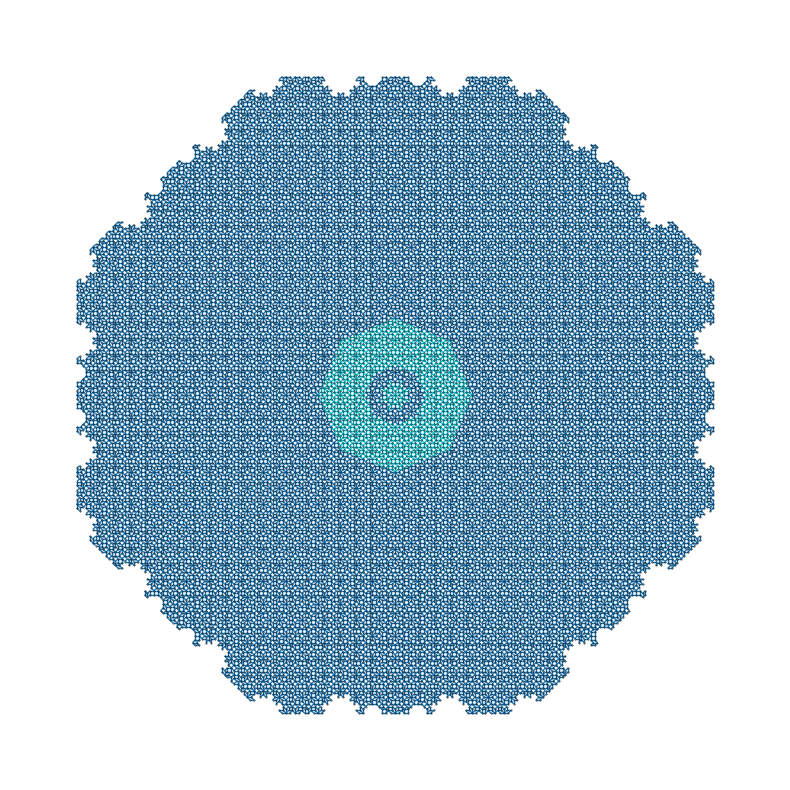

In [82]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

full_graph_visualize(cGV_edges[EV_params['case_no']] + cGE_edges[EV_params['case_no']],
                    edges=edges, nodes=nodes, nodepos=nodepos, cmap='tab10',
                    width=1,  node_size=0.1)
                    #ax=ax)


### Load the MC samples from the disk

In [83]:
######### Loading the (PRE-EXISTING) E,V data samples ##########
samples = [10705]  # EV_params['sample_seeds']

EV_dir = sample_data_dir = os.path.join('data', 'EandV')  #os.path.join(os.pardir, 'data', 'EandV') 

Es_list=[]
Vs_list=[]

for sample in samples:
    Es_list.append(np.load(os.path.join(EV_dir,"Es_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
    Vs_list.append(np.load(os.path.join(EV_dir,"Vs_%i_vi%i_c%i.npy" % (sample,EV_params['V_index'],EV_params['case_no']))))
        
Es = np.reshape(Es_list,newshape=(len(Es_list)*Es_list[0].shape[0],Es_list[0].shape[1]))
Vs = np.reshape(Vs_list,newshape=(len(Vs_list)*Vs_list[0].shape[0],Vs_list[0].shape[1], 1)) # REMEMBER about the additional axis for Vs !!!!!
print("shapes: ", Es.shape,Vs.shape)

data_params['N_samples'] = len(Vs) 
print('len(Vs): ',len(Vs))

shapes:  (50000, 2456) (50000, 88, 1)
len(Vs):  50000


In [84]:
Vs_dict = load_Vs(samples, [EV_params['case_no']],
                  EV_params['V_index'], sample_data_dir)


[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)


# Optimisation

## Optimisation hyperparameters

In [85]:
run_no = 0


In [86]:
# Linear CG ansatz

# critic_params specify the MI estimator network -- not likely you need to touch that
# CG_params specify the coarse-grainer
# opt_params the settings of the training algorithm

hidden_dim = 4  # Number of "CG variables"
discrete_var = 1  # 1 # "1" is a "discrete" CG variable, 0 is continuous.
nonlinearCG_layers = [0]

batch_size = 2000  # typically we use 400 or 800
iterations = 50 # 130  # number of epochs

# 8e-4 # 1e-5 # Gumbel-Softmax relaxation rate (from uniform to true categorical distribution)
relaxation_rate = 5e-3
# 8e-4 typically around 1e-4, but can be played with, seems to work in the range [0.2-2. e-4]
learning_rate = 5e-4

# None # pristine_f_l0 # Can be used to feed pre-trained filters.
init_rule = None #0.2 * coarse_grainers[scale][vertex_type][V_index] # filters[-1]  # purified_filters

##### Setting optimizer params ##########

CG_params = {
    'll': EV_params['block_size'],
    'size_V': Vs.shape[1],
    'init_temperature': 0.3,  # 0.4, # Gumbel-Softmax initial temperature
    'min_temperature': 0.02,  # 0.05, # Gumbel-Softmax min temperature
    'relaxation_rate': relaxation_rate,  # Gumbel-Softmax relaxation rate
    'Nq': None,  # Number of components of the d.o.f.s -- None means they will be set by default to a single component
    # If *not* using Gumbel-Softmax discretisation, this activation will be applied to the output of the coarse-grainer
    'conv_activation': 'softsign',
    'hidden_dim': hidden_dim,  # Number of "CG variables"
    'h_embed': discrete_var,  # True is discrete, False is continuous
    # [0] or None for standard linear CG coupling, a list of stacked dense layer sizes otherwise.
    'nonlinearCG': nonlinearCG_layers,
    # 'relu', # activation function of the *in-between* dense-layers. The last one doesn't have any.
    'hidden_activations': 'swish',
    # 1e-4, # L2 regularization of activations, useful with unbounded activations like relu
    'hidden_activations_L2_reg': 1e-5,
    'batch_norm': False,  # False
    'logit_scale': np.inf,  # 16
    'logit_minscale': 30,  # 30, #3 #8,
    'use_probs': False,
    'use_logits': True,  # True,
    'use_STE': True,  # False,
}

critic_params = {
    'layers': 2,
    'embed_dim': 8,  # 8
    'hidden_dim': 16,  # 32
    'activation': 'swish',  # 'relu',
    'use_dropout': True,
    'dropout_rate': 0.4,  # 0.4,
}

opt_params = {
    "batch_size": batch_size,
    "iterations": iterations,
    "shuffle": len(Vs),
    "learning_rate": learning_rate
}

run_params = {
    # to distinguish independent repetition of the experiment (other parameters being equal)
    "run_no": run_no,
    "use_GPU": True
}

all_params = {}
all_params.update(EV_params)
all_params.update(data_params)
all_params.update(CG_params)
all_params.update(critic_params)
all_params.update(opt_params)
all_params.update(run_params)
print(all_params)


{'env_size': None, 'buffer_size': None, 'block_size': None, 'sample_no': 1070512121, 'sample_seeds': [10705, 12121], 'V_index': 389, 'V_order': 4, 'case_no': 49, 'model': 'dimer_graph', 'lattice_type': 'networkx', 'L': 2048, 'N_samples': 50000, 'dimension': 2, 'll': None, 'size_V': 88, 'init_temperature': 0.3, 'min_temperature': 0.02, 'relaxation_rate': 0.005, 'Nq': None, 'conv_activation': 'softsign', 'hidden_dim': 16, 'h_embed': 1, 'nonlinearCG': [0], 'hidden_activations': 'swish', 'hidden_activations_L2_reg': 1e-05, 'batch_norm': False, 'logit_scale': inf, 'logit_minscale': 30, 'use_probs': False, 'use_logits': True, 'use_STE': True, 'layers': 2, 'embed_dim': 8, 'activation': 'swish', 'use_dropout': True, 'dropout_rate': 0.4, 'batch_size': 2000, 'iterations': 50, 'shuffle': 50000, 'learning_rate': 0.0005, 'run_no': 0, 'use_GPU': True}


In [60]:
run_no += 1

############## TRAIN (a single instance) ###############
data_params['N_samples'] = len(Vs)

estimates, Hs, filters, net = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params,
                                                          data_params, E=Es, V=Vs,
                                                          use_GPU=run_params['use_GPU'],
                                                          init_rule=init_rule, use_notebook=True)

if hidden_dim > 1:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.scatter(Hs[-1, :, 0], Hs[-1, :, 1], s=10)
    

  0%|          | 0/1250 [00:00<?, ?it/s]

Len dat:  1250


2024-04-09 13:07:10.568772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


KeyboardInterrupt: 

### Crudely visualize the training

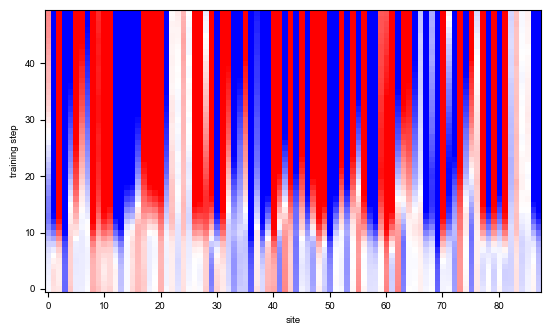

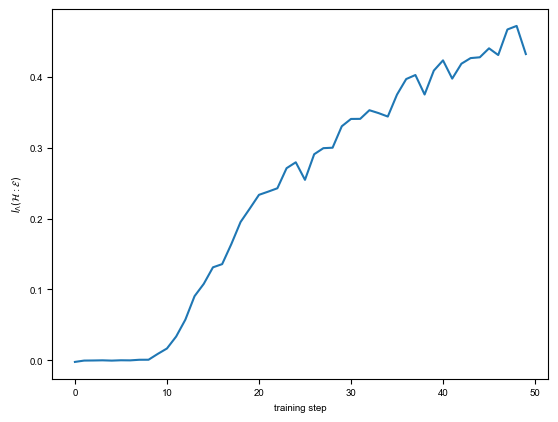

In [23]:
plt.figure()

# plot the filters (flattened to a 1D array) with time dimension going up:
if len(nonlinearCG_layers) == 1:
    heat = np.array([filters[:, i, 0]
                    for i in range(filters.shape[1])]).transpose()
    plt.imshow(heat, cmap='bwr', interpolation='nearest',
               aspect=1, origin="lower", vmin=-0.2, vmax=0.2)
else:
    heat = np.array([filters[i][0][:, 0] for i in range(len(filters))])
    plt.imshow(heat, cmap='bwr', interpolation='nearest',
               aspect=2, origin="lower", vmin=-0.2, vmax=0.2)
plt.xlabel('site')
plt.ylabel('training step')
plt.show()

%matplotlib inline

# Plot the mutual information (MI) as a function of training step:
plt.figure()

#best_estimate_id = np.nonzero(estimates>1e-1)[0][-1]

plt.plot(estimates)
#plt.axvline(best_estimate_id, color='gray', alpha=0.3)
plt.xlabel('training step')
plt.ylabel(r'$I_\Lambda(\mathcal{H}:\mathcal{E})$')
plt.show()


# Analyse the results

## Visualize the trained networks (coarse graining map)


In [87]:
# uncomment below if you want to analyse previously trained filters

filters = np.array([coarse_grainers[scale][vertex_type][V_index]])


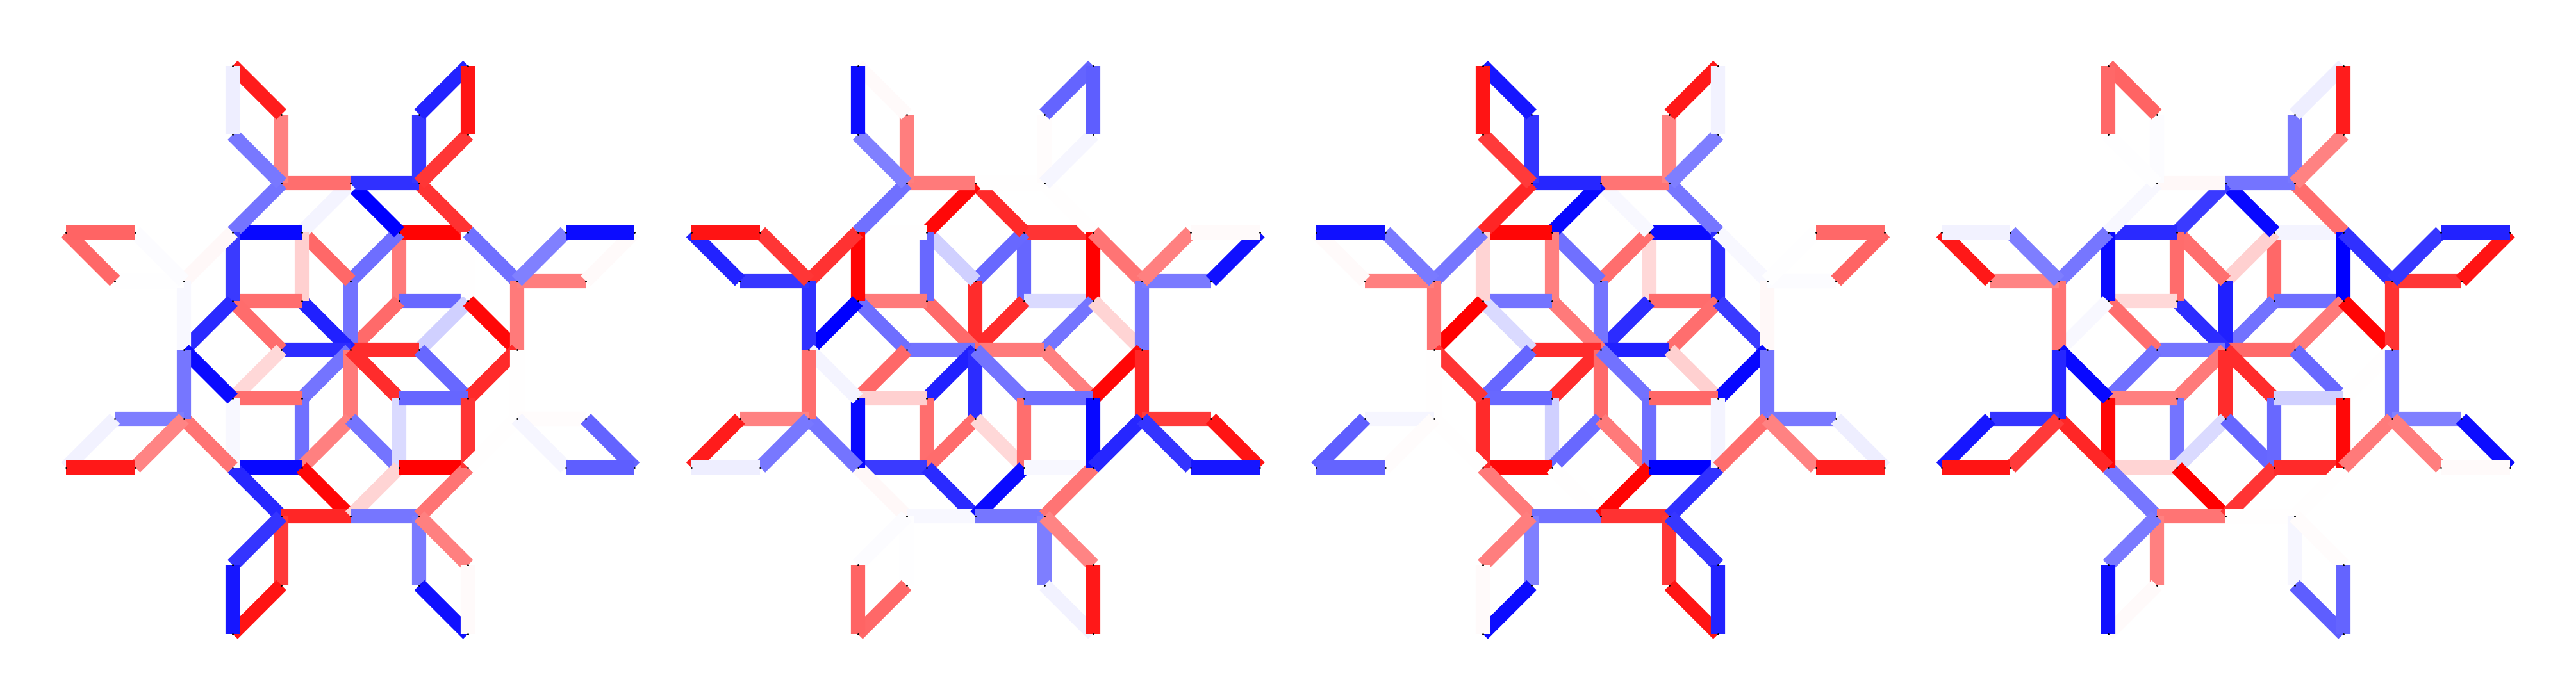

In [88]:
# The nice built-in visualization functions expect this "dictionary of cases" format of inputs.
%matplotlib inline

scale_fac = 2*int(np.ceil(np.cbrt(len(cGV_edges[EV_params['case_no']]))))
if len(nonlinearCG_layers) > 1:
    if nonlinearCG_layers[0] > 20:
        skip = nonlinearCG_layers[0] // 20
        num_cols = 20
    else:
        skip = 1
        num_cols = nonlinearCG_layers[0]

    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1][0][:, ::skip], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=num_cols, figsize=(num_cols*scale_fac, 3*scale_fac), title="hidden", width=16,)
else:
    small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1], edges=edges, nodes=nodes, nodepos=nodepos,
                      n_rows=1, n_cols=hidden_dim, figsize=(hidden_dim*scale_fac, 3*scale_fac), title="hidden", width=16)


In [89]:
coarse_grainers[scale][vertex_type][V_index] = filters[-1] 

In [90]:
small_V_visualize(cGV_edges[EV_params['case_no']], filters[-1], edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=hidden_dim, figsize=(8*cm, 1.3*cm), title="hidden", width=0.9, node_size=0,
                  savename=scale+'_'+vertex_type+'v_filters__.pdf')


a = np.array([[-np.max(filters[-1]), np.max(filters[-1])]])
plt.figure(figsize=(0.1*cm, 2*cm))
img = plt.imshow(a, cmap="bwr")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.1, 0.6, 0.8])
plt.colorbar(orientation="horizontal", cax=cax,)
cax.yaxis.set_ticks_position('right')

#plt.savefig("colorbar.pdf", bbox_inches="tight")


### Purify the filters by generating rotated components

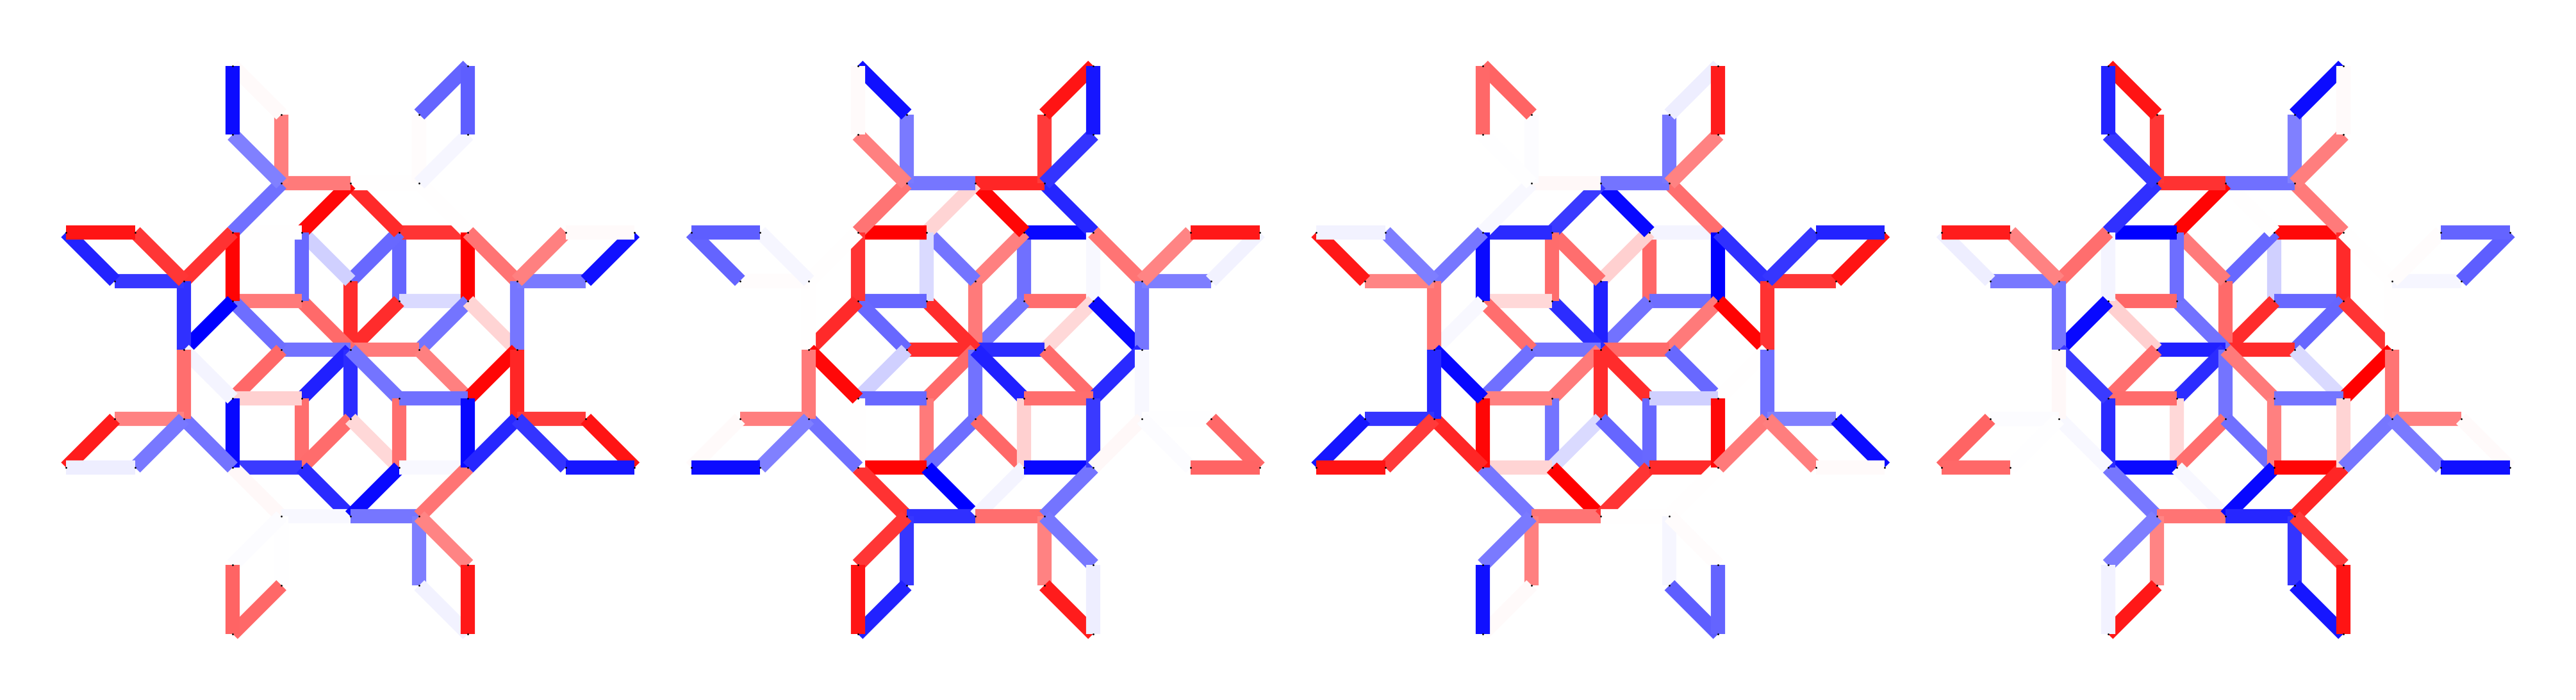

In [91]:
angle = np.pi/2

fid = 1

f = []
for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])


for i in range(2):
    subarr_pos = rotate_edges(cGV_edges[EV_params['case_no']], 5*np.pi/4+i*angle, nodepos, edges, target_vertex=V_index)
    f.append(filters[-1, subarr_pos, fid])

purified_filters = np.array(f).transpose()

small_V_visualize(cGV_edges[EV_params['case_no']], purified_filters, edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=4, figsize=(hidden_dim*scale_fac, 3*scale_fac),
                  title="hidden", width=16)


In [92]:
coarse_grainers[scale][vertex_type][V_index] = purified_filters

#### Regularisation

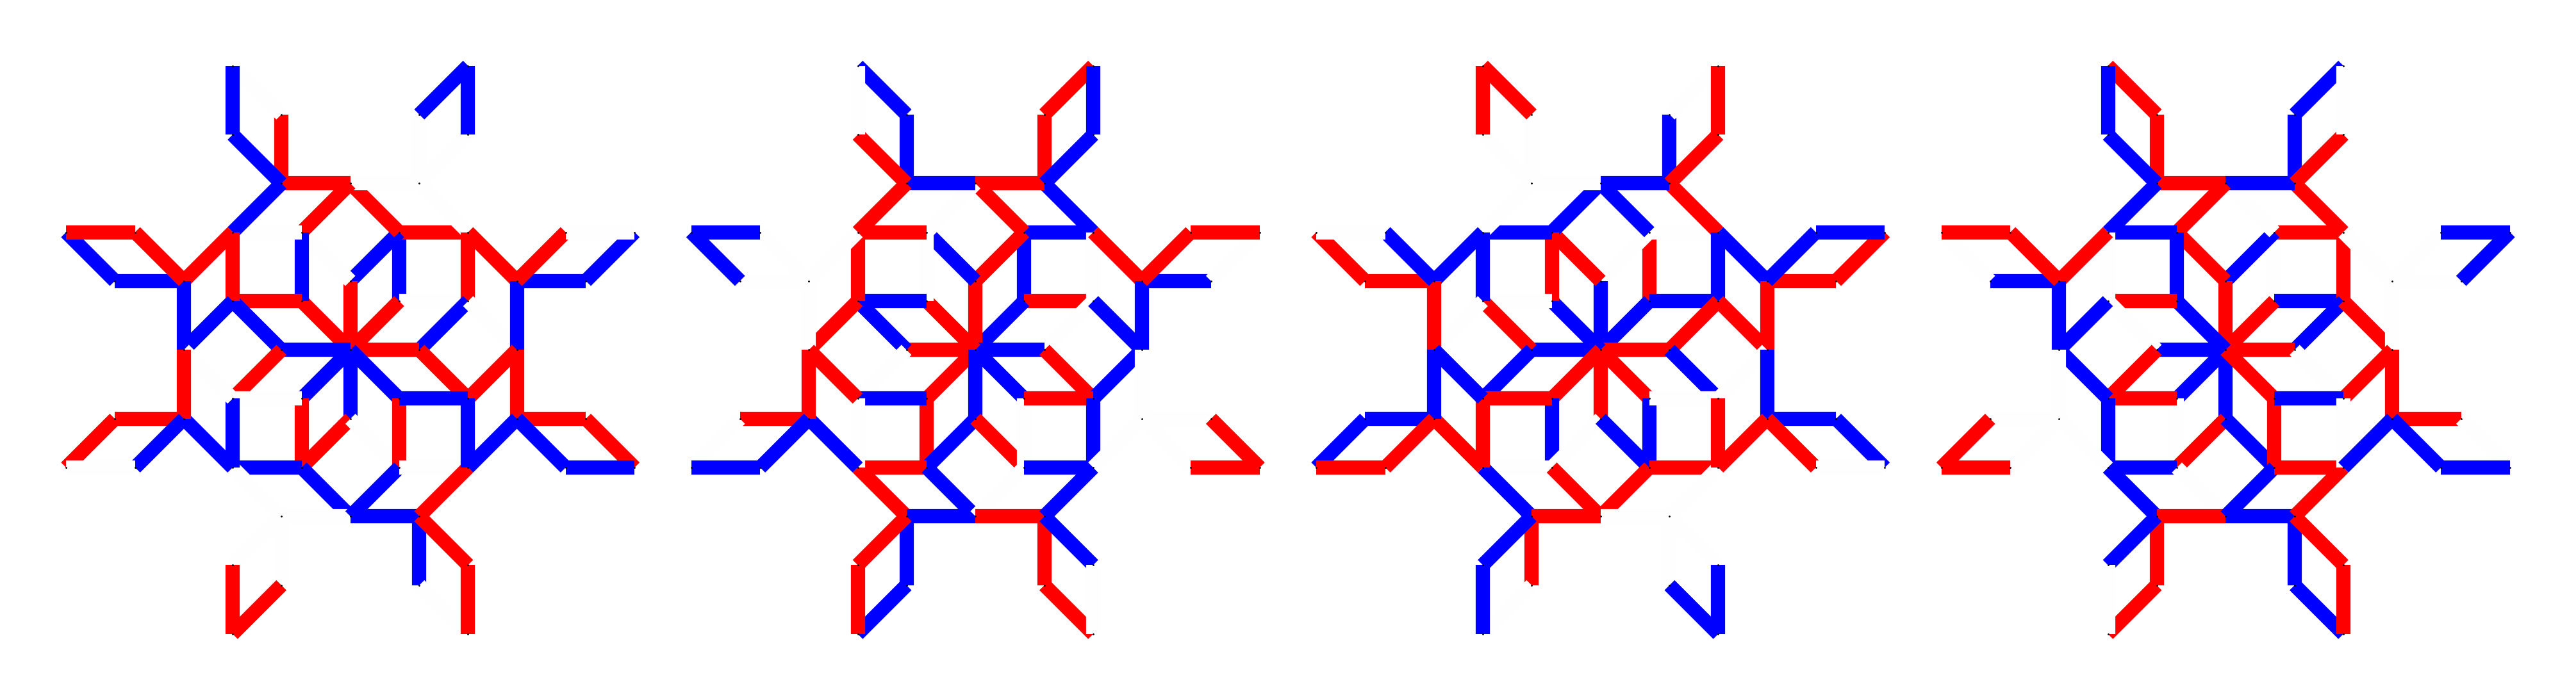

In [93]:
a = np.copy(purified_filters)

a[np.abs(a) < 0.5] = 0
a[a > 0.5] = 2
a[a < -0.5] = -2

small_V_visualize(cGV_edges[EV_params['case_no']], a, edges=edges, nodes=nodes, nodepos=nodepos,
                  n_rows=1, n_cols=hidden_dim, figsize=(hidden_dim*scale_fac, 3*scale_fac), title="hidden", width=16)


### Distribution of pre-activations

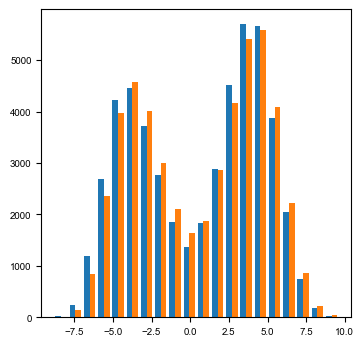

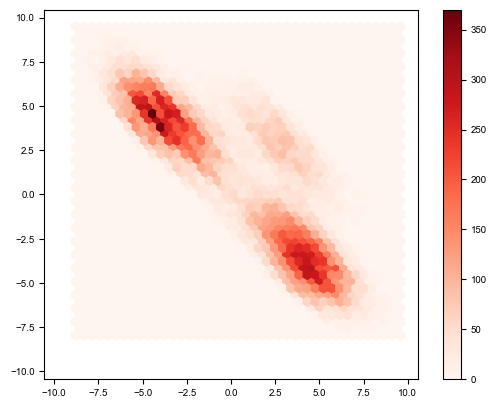

In [65]:
test_prods = dot_prod_V(Vs_dict[case_no][:, :, 0], None, filters[-1])

fig = plt.figure(figsize=(4, 4))
plt.hist(test_prods[:], bins=20)

hexbin_visualize(test_prods[:, 0], test_prods[:, 1], gridsize=40)


## Analysis of the coarse-grained variables

### Distribution of the variables $\mathcal{H}$

First compute the coarse-grained variables $\mathcal{H}$ for each sample using the optimised map and exact discretisation.

In [94]:
cond8 = False

if cond8 is True: 
    cond3 = False
else:
    cond3 = True

In [95]:
vertex_type_corr = '8'
# TODO: handle the case where there are more than one V_index in a given vertex type

if vertex_type_corr == '8':
    V_index_corr = 389
    
elif vertex_type_corr == '3E':
    V_index_corr = 13554 # (southwest) 
elif vertex_type_corr == '3NE':
    V_index_corr = 16830 # (south)  
elif vertex_type_corr == '3N':
    V_index_corr = 20098  # (southeast)
elif vertex_type_corr == '3NW':
    V_index_corr = 404 # (east)
elif vertex_type_corr == '3W':
    V_index_corr = 399 # (northeast)
elif vertex_type_corr == '3SW':
    V_index_corr = 3742 # (north)
elif vertex_type_corr == '3S':
    V_index_corr = 7010 # (northwest)
elif vertex_type_corr == '3SE':
    V_index_corr = 10286 # (west)

elif vertex_type_corr == '3':
    V_index_corr = 16830 # (south)  #13554 # (southwest) # case_dict[scale][vertex_type]['V_index']

if vertex_type_corr == '8':
    hidden_dim = 4
elif vertex_type_corr[0] == '3':
    hidden_dim = 2

coarse_grainer = coarse_grainers[scale][vertex_type_corr[0]][V_index_corr]

Vs_dict = load_Vs(samples, [case_dict[scale][vertex_type_corr[0]]['case_no']], V_index_corr, sample_data_dir)


[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)


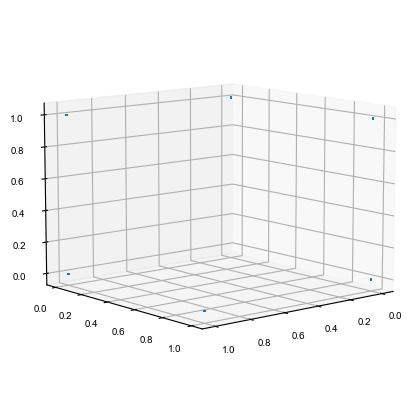

In [96]:
%matplotlib inline

#case_no = case_no

#test_pr = net(Vs_dict[case_no]).numpy()

test_pr = np.heaviside(dot_prod_V(Vs_dict[case_dict[scale][vertex_type_corr[0]]['case_no']][:, :, 0],
                                  None, coarse_grainer), 0)


fig = plt.figure(figsize=(5, 5))


if hidden_dim > 2:
    ax = fig.add_subplot(projection='3d')
    ax.scatter(test_pr[:, 0], test_pr[:, 1], test_pr[:, 2], s=0.01)
    #ax.set_zlim(-1,1)
    ax.view_init(10, 50)
if hidden_dim == 2:
    ax = fig.add_subplot()
    ax.scatter(test_pr[:, 0], test_pr[:, 1], s=0.01)


### Analyse the statistics of bitstrings

In [97]:
counts, labels, all_labels, hist = embedding_statistics(test_pr, CG_params)#hidden_dim)


(-0.5, 15.5)

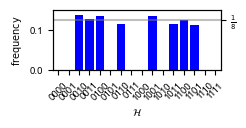

In [98]:
if hidden_dim == 4:
    fig, ax = plt.subplots(1, figsize=(5.5*cm, 2*cm))
elif hidden_dim == 2:
    fig, ax = plt.subplots(1, figsize=(3*cm, 2.3*cm))

if vertex_type_corr=='8':
    colour = 'b'
elif vertex_type_corr=='3':
    colour = 'r'

freqs = {key: counts[key]/len(test_pr) for key in counts}

ymax = 1.1 * max(freqs.values())

ax.axhline(1/8, color='gray', linestyle='-', label=r'$1/8}$', alpha=0.5)
ax.bar(all_labels, freqs.values(), color=colour,)

ax.set_ylabel(r'${\rm frequency}$')
ax.set_xlabel(r'$\mathcal{H}$')
ax.tick_params(axis='x', labelrotation=45)

ax2 = ax.twinx()
ax2.set_yticks([1/8])
ax2.set_yticklabels([r'$\frac{1}{8}$'])
ax2.set_ylim([0, ymax])
ax.set_ylim([0, ymax])
ax.set_xlim([-.5, 2**hidden_dim - .5])

#plt.savefig(scale+'_'+vertex_type+'v_dist.pdf', dpi=500, bbox_inches='tight')


In [99]:
# sort the bitstrings around a cycle (if a unique cycle exists)

sorted_labels = [labels[0]]
temp = labels[1:]

while len(temp) > 0:
    
    for check in temp:
        if hamming2(check, sorted_labels[-1]) == 1:
            sorted_labels.append(check)
            temp.remove(check)
            break

if vertex_type_corr == '8':
    sorted_labels_8 = sorted_labels

sorted_labels


['1100', '1101', '1001', '1011', '0011', '0010', '0110', '0100']

# Analysis of the correlations

Filter the samples in the current coarse graining according to the labels in the previous coarse graining.


Filtering current representation for symbol (1, 1) from previous run.


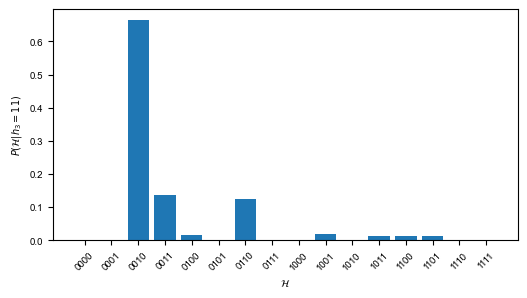

In [100]:
state = 2
symbol = list(CGfilter_corrr.keys())[state]
str_symbol = "".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))

#str_symbol = sorted_labels_8[state]
#symbol = tuple([int(char) for char in sorted_labels_8[state]])


print('Filtering current representation for symbol',
      symbol,
      'from previous run.')


Hs_filtered = test_pr[CGfilter_corrr[symbol]]
#print(row_counter(Hs_filtered))

counts_filtered, labels_filtered, _, _ = embedding_statistics(Hs_filtered, CG_params)


freqs_filtered = {key: counts_filtered[key]/len(Hs_filtered) for key in counts}

fig, ax = plt.subplots(1, figsize=(6, 3))

ax.bar(all_labels, freqs_filtered.values())
ax.set_ylabel(r'$P(\mathcal{H}|h_3='+str_symbol+')$')
ax.set_xlabel('$\mathcal{H}$')

ax.tick_params(axis='x', labelrotation=45)


In [110]:
peak_code = '0010'

hamming2(peak_code, '0000') 

var = 0
for code in labels_filtered:
    dist = hamming2(code, peak_code)
    var += freqs_filtered[code] * dist
    
var

0.4688633138893269

In [109]:
freqs_filtered


{'0000': 0.0,
 '0001': 0.0,
 '0010': 0.6641967523253981,
 '0011': 0.13668611067318304,
 '0100': 0.015450102475169479,
 '0101': 0.0,
 '0110': 0.12517736087025066,
 '0111': 0.0,
 '1000': 0.0,
 '1001': 0.01765725997162226,
 '1010': 0.0,
 '1011': 0.01308529087182721,
 '1100': 0.014031215513164118,
 '1101': 0.01371590729938515,
 '1110': 0.0,
 '1111': 0.0}

### Create a sample filter for the labels (Don't update this after each optimisation!)

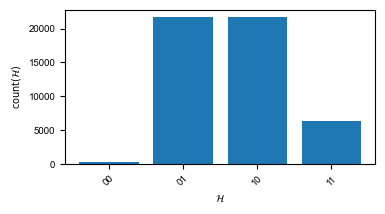

In [79]:
#%matplotlib notebook

fig, ax = plt.subplots(1, figsize=(4, 2))

ax.bar(all_labels, counts.values())
ax.set_ylabel(r'${\rm count}(\mathcal{H})$')
ax.set_xlabel(r'$\mathcal{H}$')

ax.tick_params(axis='x', labelrotation=45)


In [80]:
CGfilter_corrr = dict()

# returns the sample indices with given CG state
for label in hist.keys():
    if CG_params['use_logits']:
        CGfilter_corrr[label] = np.where(
            np.all(np.heaviside(test_pr-0.5, 0) == list(label), axis=1))[0]
    else:
        CGfilter_corrr[label] = np.where(
            np.all(np.sign(test_pr) == list(label), axis=1))[0]

CGfilter_corrr


{(1, 0): array([    0,     1,     5, ..., 49994, 49996, 49998]),
 (0, 1): array([    2,     4,     6, ..., 49995, 49997, 49999]),
 (1, 1): array([    3,    16,    18, ..., 49982, 49984, 49993]),
 (0,
  0): array([  190,   499,   518,   540,   752,  1397,  1449,  1541,  1882,
         1913,  1957,  2078,  2093,  2288,  2424,  2602,  2625,  2651,
         2699,  2760,  3130,  3255,  3498,  3509,  3976,  4014,  4465,
         4624,  5262,  5377,  5385,  5633,  5789,  6015,  6118,  6205,
         6228,  6465,  6680,  6987,  7058,  7177,  7196,  7591,  7908,
         8116,  8196,  8364,  8758,  9239,  9300,  9388,  9424,  9555,
         9634,  9719, 10382, 10527, 10679, 11131, 11362, 11507, 11539,
        11541, 11548, 12049, 12203, 12303, 12824, 12942, 13014, 13346,
        13645, 13778, 13806, 13929, 13960, 13991, 14043, 14069, 14267,
        14342, 14481, 14502, 14580, 14614, 14980, 15134, 15342, 15391,
        15547, 15616, 15636, 15713, 15827, 16180, 16524, 16652, 17007,
        17093,

## Streamline correlation analysis

Define functions to analyse the coarse-grained codes, automate identification of clock variables and compute correlations.

In [26]:
def sort_bitstrings(labels):

    # sort the bitstrings around a cycle (if a unique cycle exists)
    sorted_labels = [labels[0]]
    temp = labels[1:]

    while len(temp) > 0:

        for check in temp:
            if hamming2(check, sorted_labels[-1]) == 1:
                sorted_labels.append(check)
                temp.remove(check)
                break

    return sorted_labels

def samples2bitstrings(vertex_type: str, sparse_freqs: bool = True):
    """
    state: conditioning state
    vertex_type_corr: vertex type that will be filtered
    cond8: if the contitioning vertex an 8-vertex

    """


    if vertex_type == '8':
        V_index_corr = 389
    elif vertex_type == '3E':
        V_index_corr = 13554 # (southwest) 
    elif vertex_type == '3NE':
        V_index_corr = 16830 # (south)  
    elif vertex_type == '3N':
        V_index_corr = 20098  # (southeast)
    elif vertex_type == '3NW':
        V_index_corr = 404 # (east)
    elif vertex_type == '3W':
        V_index_corr = 399 # (northeast)
    elif vertex_type == '3SW':
        V_index_corr = 3742 # (north)
    elif vertex_type == '3S':
        V_index_corr = 7010 # (northwest)
    elif vertex_type == '3SE':
        V_index_corr = 10286 # (west)
    else:
        raise ValueError('vertex_type_corr not recognized')


    if vertex_type == '8':
        hidden_dim = 4
    elif vertex_type[0] == '3':
        hidden_dim = 2

    coarse_grainer = coarse_grainers[scale][vertex_type[0]][V_index_corr]

    Vs_dict = load_Vs(samples, [
                      case_dict[scale][vertex_type[0]]['case_no']], V_index_corr, sample_data_dir)

    test_pr = np.heaviside(dot_prod_V(Vs_dict[case_dict[scale][vertex_type[0]]['case_no']][:, :, 0],
                                      None, coarse_grainer), 0)

    counts, labels, all_labels, hist = embedding_statistics(test_pr, CG_params, hidden_dim=hidden_dim)
    freqs = {key: counts[key]/len(test_pr) for key in counts}

    if sparse_freqs:
        freqs = {k: v for k, v in freqs.items() if v > 0.02}

    return freqs, test_pr, hist


In [27]:
def create_sample_filter(vertex_type_corr: str):    
    freqs, test_pr, hist = samples2bitstrings(vertex_type_corr)

    CGfilter_corrr = dict()

    # returns the sample indices with given CG state
    for str_symbol in freqs.keys():
        label = tuple([int(char) for char in str_symbol])
        if CG_params['use_logits']:
            CGfilter_corrr[label] = np.where(
                np.all(np.heaviside(test_pr-0.5, 0) == list(label), axis=1))[0]
        else:
            CGfilter_corrr[label] = np.where(
                np.all(np.sign(test_pr) == list(label), axis=1))[0]

    return CGfilter_corrr


In [28]:
def filter_bitstrings(state: int, vertex_type_corr:str, CGfilter_corrr: dict, cond8: bool=False):
    """
    state: conditioning state for the filter
    vertex_type: type of vertex which will be filtered
    CG_filter_corrr: filter holding the sample dictionary

    """

    if cond8 is True: 
        cond3 = False
    else:
        cond3 = True

    if vertex_type_corr == '8':
        hidden_dim = 4
    elif vertex_type_corr[0] == '3':
        hidden_dim = 2
    
    
    if cond8:
        sorted_labels_8 = sort_bitstrings(["".join(map(str, (0.5*(np.array(symbol)+1)).astype(int))) 
                                                                for symbol in CGfilter_corrr.keys()])
        str_symbol = sorted_labels_8[state]
        symbol = tuple([int(char) for char in str_symbol])
        
    elif cond3:
        symbol = list(CGfilter_corrr.keys())[state]
        str_symbol = "".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))
    
    _, test_pr, _ = samples2bitstrings(vertex_type_corr)
    Hs_filtered = test_pr[CGfilter_corrr[symbol]]

    counts_filtered, labels_filtered, _, _ = embedding_statistics(Hs_filtered, CG_params, hidden_dim=hidden_dim)

    freqs_filtered = {key: counts_filtered[key]/len(Hs_filtered) for key in counts_filtered}

    return freqs_filtered

In [29]:
def filter_all_vertices(state: int, CGfilter_corrr: dict, cond8: bool=False, 
                        vertices: list=['3E', '3NE']):

    freqs_filtered_all = {}

    vertex_type_corr = '8'

    freqs, _, _ = samples2bitstrings(vertex_type_corr, sparse_freqs=True)
    labels = list(freqs.keys())
    sorted_labels = sort_bitstrings(labels)

    freqs_filtered = filter_bitstrings(state, vertex_type_corr, CGfilter_corrr, cond8=cond8)
    print('debugging', freqs_filtered)

    freqs_filtered_cleaned = {}
    for label in sorted_labels:
        freqs_filtered_cleaned[label] = freqs_filtered[label]

    freqs_filtered_all[vertex_type_corr] = freqs_filtered_cleaned



    for vertex_type_corr in vertices:

        freqs, _, _ = samples2bitstrings(vertex_type_corr, sparse_freqs=True)
        labels = list(freqs.keys())
        sorted_labels = sort_bitstrings(labels)
        freqs_filtered = filter_bitstrings(state, vertex_type_corr, CGfilter_corrr, cond8=cond8)

        freqs_cleaned = freqs.copy()
        sorted_labels_cleaned = sorted_labels.copy()

        """
        spurious_code = min(freqs_cleaned, key=freqs_cleaned.get)

        print(
            f'will now remove {spurious_code} with frequency {freqs_cleaned[spurious_code]}')

        del freqs_cleaned[spurious_code]
        sorted_labels_cleaned.remove(spurious_code)

        print(freqs_cleaned)
        print(sorted_labels_cleaned)


        freqs_filtered_cleaned = {}

        for label in sorted_labels_cleaned:
            freqs_filtered_cleaned[label] = freqs_filtered[label]
        """

        freqs_filtered_all[vertex_type_corr] = freqs_filtered#_cleaned

    return freqs_filtered_all

In [30]:
def construct_correlation_graph(freqs_filtered_all: dict, cond8: bool=False,
                                compass_dict=None, ref_dirs=None, cond_dir = None,
                                dimer_width=4,
                                dw_eps=0.8,
                                l_width=0.1,
                                ncolor='grey',
                                nsize=45,
                                ccolor='darkorange',
                                ax=None,
                                colorbar: bool=False,
                                cpermute=0,
                                cflip=False,):

    if cond8 is True:
        cond3 = False

    else:
        cond3 = True



    if ref_dirs is None:
        ref_dirs = np.array(['3E', '3SE', '3S', '3SW', '3W', '3NW', '3N', '3NE'])

    if cond_dir is None:
        cond_dir = '3NE'

    ref_dir_dict = {'3N':  3730, '3NE': 390, '3E': 388, '3SE': 20090,
                    '3S': 16818, '3SW': 13546, '3W': 10274, '3NW': 7002,
                    '8': 389}

    
    edges_dict = {389: [796, 797, 798, 799, 800, 801, 802, 803],
                390: [797, 793, 7438],
                388: [796, 46282, 792],
                20090: [803, 39810, 46284],
                16818: [802, 33336, 39808],
                13546: [801, 26862, 33334],
                10274: [800, 20388, 26860],
                7002: [799, 13914, 20386],
                3730: [798, 7440, 13912]}  # TODO: make sure the edges are ordered counter-clockwise!!


    if compass_dict is None:
        # Dictionary of oriented clock states (sorted CCW) at each 3-vertex (denoted by direction)
        # TODO: construct this dictionary automatically
        compass_dict = {'3E': ['10', '11', '00'],
                        '3NE': ['11', '01', '10'],
                        '3N': ['11', '10', '01'],
                        '3NW': ['11', '10', '01'],
                        '3W': ['11', '10', '01'],
                        '3SW': ['01', '00',  '11'],
                        '3S': ['11', '10', '01'],
                        '3SE': ['11', '01', '10']}


    corr_graphs = {}

    # central 8-vertex:
    node_id = ref_dir_dict['8']
    V_edgelist = region_of_interest = edges_dict[node_id]

    if cond8:
        A = np.zeros(8)
        A[state] = 1
        edge_densitiesc = A
    elif cond3:
        edge_densitiesc = np.array(list(freqs_filtered_all['8'].values()))

    # TODO: make sure this is correct and safe!
    #permute = np.where(ref_dirs == cond_dir)[0][0] - np.argmax(edge_densitiesc)
    #print(permute)
    edge_densitiesc = np.roll(edge_densitiesc, cpermute) #np.flip(np.roll(edge_densitiesc, 0))
    if cflip:
        edge_densitiesc = np.flip(edge_densitiesc)
    

    Rc = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
            'colors': edge_densitiesc[num]}) for num, e_ind in enumerate(V_edgelist)]
    Rc.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
            for i in range(num_vtx)}
    nx.set_node_attributes(Rc, ndict)

    pos_Vc = nx.get_node_attributes(Rc, 'pos')
    node_id = 389
    pos_V_scaledc = pos_Vc.copy()
    for node, pos in pos_Vc.items():
        if node != node_id:
            scaled_pos = 0.5 * (np.array(pos) + np.array(pos_Vc[node_id]))
            print(scaled_pos)

            pos_V_scaledc[node] = tuple(scaled_pos)

    corr_graphs['8'] = (Rc, pos_Vc, pos_V_scaledc, edge_densitiesc)


    # 3-vertices:

    for dir in ref_dirs:
        node_id = ref_dir_dict[dir]
        print(dir, node_id)

        V_edgelist = region_of_interest = edges_dict[node_id]
        print(region_of_interest)

        if dir == cond_dir:
            if cond3 and dir[0]=='3':
                symbol = list(CGfilter_corrr.keys())[state]
                str_symbol = "".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))
                
                direction = np.where(np.array(compass_dict[dir]) == str_symbol)[0][0]
                edge_densities1 = np.zeros(3)
                edge_densities1[direction] = 1
            elif cond8:
                edge_densities1 = np.array([freqs_filtered_all[dir][k] for k in compass_dict[dir]])

        else:
            print(dir)
            edge_densities1 = np.array([freqs_filtered_all[dir][k] for k in compass_dict[dir]])
            

        R1 = nx.Graph()
        elist = [(edges[e_ind, 0], edges[e_ind, 1], {
                'colors': edge_densities1[num]}) for num, e_ind in enumerate(V_edgelist)]
        R1.add_edges_from(elist)

        num_vtx = np.shape(nodes)[0]
        ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
                for i in range(num_vtx)}
        nx.set_node_attributes(R1, ndict)

        pos_V1 = nx.get_node_attributes(R1, 'pos')

        pos_V_scaled1 = pos_V1.copy()
        for node, pos in pos_V1.items():
            if node != node_id:
                scaled_pos = 0.5 * (np.array(pos) + np.array(pos_V1[node_id]))
                print(scaled_pos)

                pos_V_scaled1[node] = tuple(scaled_pos)

        corr_graphs[dir] = (R1, pos_V1, pos_V_scaled1, edge_densities1)



    # Plot the graph
    #fig, ax = plt.subplots(figsize=(5*cm, 5.5*cm))
    ax = ax or plt.gca()
    ax.set_aspect('equal')

    for corr_graph in corr_graphs.values():
        nx.draw(corr_graph[0], corr_graph[1], 
                node_color=ncolor,
                edge_color='grey',
                width=l_width, 
                node_size=nsize, ax=ax)



    for dir in corr_graphs.keys():
        R, pos_V, pos_V_scaled, edge_densities = corr_graphs[dir]
        nx.draw_networkx_edges(R, pos_V_scaled,
                            edge_color='k', width=dimer_width+dw_eps)

        if dir == '8':
            continue
        elif dir == cond_dir:
            if cond3:
                nx.draw(R, pos_V_scaled, node_color=ncolor,
                        edge_color=edge_densities,
                        edge_cmap=mpl.colors.LinearSegmentedColormap.from_list(
                            '', ['white', ccolor]), linewidths=10,
                        edge_vmin=0, edge_vmax=1,
                        width=dimer_width, node_size=0, ax=ax)
            elif cond8:
                nx.draw(R, pos_V_scaled, node_color=ncolor,
                        edge_color=edge_densities,
                        edge_cmap=plt.cm.Greys, linewidths=10,
                        edge_vmin=0, edge_vmax=1,
                        width=dimer_width, node_size=0, ax=ax)
        else:
            nx.draw(R, pos_V_scaled, node_color=ncolor,
                    edge_color=edge_densities,
                    edge_cmap=plt.cm.Greys, linewidths=10,
                    edge_vmin=0, edge_vmax=1,
                    width=dimer_width, node_size=0, ax=ax)
            



    Rc, _, pos_V_scaledc, edge_densitiesc = corr_graphs['8']

    if cond3:
        im = nx.draw(Rc, pos_V_scaledc, node_color=ncolor,
                    edge_color=edge_densitiesc,
                    edge_cmap=plt.cm.Greys,
                    edge_vmin=0, edge_vmax=1,
                    width=dimer_width, node_size=0, ax=ax)
    elif cond8:
        im = nx.draw(Rc, pos_V_scaledc, node_color=ncolor,
                    edge_color=edge_densitiesc,
                    edge_cmap=mpl.colors.LinearSegmentedColormap.from_list(
                        '', ['white', ccolor]),
                    edge_vmin=0, edge_vmax=1,
                    width=dimer_width, node_size=0, ax=ax)




In [31]:
def construct_correlation_graph_(freqs_filtered_all: dict, cond8: bool=False,
                                dimer_width=4,
                                dw_eps=0.8,
                                l_width=0.1,
                                ncolor='grey',
                                nsize=45,
                                ccolor='cyan',
                                ax=None,
                                colorbar:bool=False):

    edges_dict = {389: [796, 797, 798, 799, 800, 801, 802, 803],
                  196: [797, 793, 7438],
                  274: [796, 46282, 792]}
        


    dir_dict = {0: [1, 1, 1], 1: [0, 1, 0], 2: [0, 0, 1], 3:[1, 0, 0]}

    # Node 196

    V_edgelist = region_of_interest = edges_dict[196]
    print(region_of_interest)


    if cond8 is True:
        cond3 = False
        edge_densities1 = np.flip(np.roll(np.array(list(freqs_filtered_all['3NE'].values())), 1))
    else:
        cond3 = True
        edge_densities1 =  dir_dict[state]



    R1 = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
            'colors': edge_densities1[num]}) for num, e_ind in enumerate(V_edgelist)]
    R1.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
            for i in range(num_vtx)}
    nx.set_node_attributes(R1, ndict)

    pos_V1 = nx.get_node_attributes(R1, 'pos')

    node_id = 390
    pos_V_scaled1 = pos_V1.copy()
    for node, pos in pos_V1.items():
        if node != node_id:
            scaled_pos = 0.5 * \
                (np.array(pos) -
                np.array(pos_V1[node_id])) + np.array(pos_V1[node_id])
            print(scaled_pos)

            pos_V_scaled1[node] = tuple(scaled_pos)


    # Node 274

    V_edgelist = region_of_interest = edges_dict[274]
    print(region_of_interest)
    edge_densities0 = np.array(list(freqs_filtered_all['3E'].values()))

    edge_densities0 = np.roll(edge_densities0, -2)


    R0 = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
            'colors': edge_densities0[num]}) for num, e_ind in enumerate(V_edgelist)]
    R0.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
            for i in range(num_vtx)}
    nx.set_node_attributes(R0, ndict)

    pos_V0 = nx.get_node_attributes(R0, 'pos')

    node_id = 388
    pos_V_scaled0 = pos_V0.copy()
    for node, pos in pos_V0.items():
        if node != node_id:
            scaled_pos = 0.5 * \
                (np.array(pos) -
                np.array(pos_V0[node_id])) + np.array(pos_V0[node_id])
            print(scaled_pos)

            pos_V_scaled0[node] = tuple(scaled_pos)


    # Node 389

    V_edgelist = region_of_interest = edges_dict[389]
    print(region_of_interest)


    if cond8:
        A = np.zeros(8)
        A[state] = 1
        edge_densitiesc = A
        #edge_densitiesc = np.roll(edge_densitiesc, 4)
    elif cond3:
        edge_densitiesc = np.array(list(freqs_filtered_all['8'].values()))

    permute = np.where(ref_dirs == cond_dir)[0][0] - np.argmax(edge_densitiesc)
    print(permute)
    edge_densitiesc = np.roll(edge_densitiesc, -1)

    Rc = nx.Graph()
    elist = [(edges[e_ind, 0], edges[e_ind, 1], {
            'colors': edge_densitiesc[num]}) for num, e_ind in enumerate(V_edgelist)]
    Rc.add_edges_from(elist)

    num_vtx = np.shape(nodes)[0]
    ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
            for i in range(num_vtx)}
    nx.set_node_attributes(Rc, ndict)

    pos_Vc = nx.get_node_attributes(Rc, 'pos')
    node_id = 389
    pos_V_scaledc = pos_Vc.copy()
    for node, pos in pos_Vc.items():
        if node != node_id:
            scaled_pos = 0.5 * \
                (np.array(pos) -
                np.array(pos_Vc[node_id])) + np.array(pos_Vc[node_id])
            print(scaled_pos)

            pos_V_scaledc[node] = tuple(scaled_pos)


    
    # Plot the correlation graph
    
    #fig, ax = plt.subplots(figsize=figsize)
    ax = ax or plt.gca()

    ax.set_aspect('equal')

    nx.draw(R1, pos_V1, node_color=ncolor,
            edge_color='grey',
            width=l_width, node_size=nsize, ax=ax)

    nx.draw(R0, pos_V0, node_color=ncolor,
            edge_color='grey',
            width=l_width, node_size=nsize, ax=ax)

    nx.draw(Rc, pos_Vc, node_color=ncolor,
            edge_color='grey',
            width=l_width, node_size=nsize, ax=ax)


    nx.draw_networkx_edges(R1, pos_V_scaled1,
                        edge_color='k', width=dimer_width+dw_eps)

    if cond3:
        nx.draw(R1, pos_V_scaled1, node_color=ncolor,
                edge_color=edge_densities1,
                edge_cmap=mpl.colors.LinearSegmentedColormap.from_list(
                '', ['white', ccolor]), linewidths=10,
                edge_vmin=0, edge_vmax=1,
                width=dimer_width, node_size=0, ax=ax)
    elif cond8:
        nx.draw(R1, pos_V_scaled1, node_color=ncolor,
                edge_color=edge_densities1,
                edge_cmap=plt.cm.Greys, linewidths=10,
                edge_vmin=0, edge_vmax=1,
                width=dimer_width, node_size=0, ax=ax)


    nx.draw_networkx_edges(R0, pos_V_scaled0,
                        edge_color='k', width=dimer_width+dw_eps)


    nx.draw(R0, pos_V_scaled0, node_color=ncolor,
            edge_color=edge_densities0,
            edge_cmap=plt.cm.Greys,
            edge_vmin=0, edge_vmax=1,
            width=dimer_width, node_size=0, ax=ax)

    nx.draw_networkx_edges(Rc, pos_V_scaledc,
                        edge_color='k', width=dimer_width+dw_eps)

    if cond3:
        im = nx.draw(Rc, pos_V_scaledc, node_color=ncolor,
                edge_color=edge_densitiesc,
                edge_cmap=plt.cm.Greys,
                edge_vmin=0, edge_vmax=1,
                width=dimer_width, node_size=0, ax=ax)
    elif cond8:
        im = nx.draw(Rc, pos_V_scaledc, node_color=ncolor,
                edge_color=edge_densitiesc,
                edge_cmap=mpl.colors.LinearSegmentedColormap.from_list(
                            '', ['white', ccolor]),
                edge_vmin=0, edge_vmax=1,
                width=dimer_width, node_size=0, ax=ax)


    if colorbar:
        cax = make_axes_locatable(ax).append_axes('bottom', size='3%', pad=0.05)

        if cond8:
                sorted_labels_8 = sort_bitstrings(["".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))
                                                for symbol in CGfilter_corrr.keys()])
                str_symbol = sorted_labels_8[state]
                symbol = tuple([int(char) for char in str_symbol])

        elif cond3:
                symbol = list(CGfilter_corrr.keys())[state]
                str_symbol = "".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))
                
        fig.colorbar(im, cax=cax, orientation='horizontal', cmap=plt.cm.Greys,
                     fraction=0.046, label=r'$P(\mathcal{H}|h_{3}='+str_symbol+')$')
        return cax


        

#plt.savefig('sigma4_correlations_5.pdf', dpi=300, bbox_inches='tight')



## Compute the correlations

[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
Condition: 1100
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
debugging {'0000': 0.0, '0001': 0.0, '0010': 0.0, '0011': 0.0, '0100': 0.0, '0101': 0.0, '0110': 0.0, '0111': 0.0, '1000': 0.0, '1001': 0.0, '1010': 0.0, '1011': 0.0, '1100': 1.0, '1101': 0.0, '1110': 0.0, '1111': 0.0}
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
C

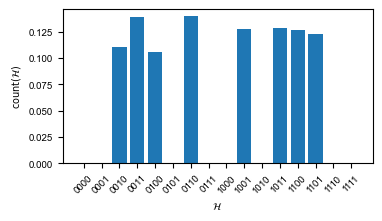

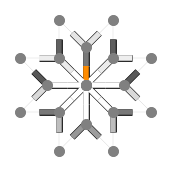

In [32]:
state = 5
cond_loc = '8'
CGfilter_corrr = create_sample_filter(cond_loc)


if cond_loc == '8':
    cond8 = True
    hdim = 4
    sorted_labels_8 = sort_bitstrings(["".join(map(str, (0.5*(np.array(symbol)+1)).astype(int)))
                                       for symbol in CGfilter_corrr.keys()])
    print('Condition:', sorted_labels_8[state])

else:
    cond8 = False
    hdim = 2
    print('Condition:', list(CGfilter_corrr.keys())[state])



freqs, test_pr, hist = samples2bitstrings(cond_loc, sparse_freqs=False)
fig, ax = plt.subplots(1, figsize=(4, 2))
ax.bar(genbitstrings(hdim), freqs.values())
ax.set_ylabel(r'${\rm count}(\mathcal{H})$')
ax.set_xlabel(r'$\mathcal{H}$')
ax.tick_params(axis='x', labelrotation=45)


figsize = (5*cm, 5*cm)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 1, 1)


freqs_filtered_all = filter_all_vertices(state, CGfilter_corrr, cond8=cond8, 
                                            vertices=['3E', '3SE', '3S', '3SW', '3W', '3NW', '3N', '3NE'])

construct_correlation_graph(freqs_filtered_all, cond8=cond8, ax=ax1, colorbar=True, cpermute=5)


### Generate $\sigma^{-2}$ part of Fig.4

[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
debugging {'0000': 0.0, '0001': 0.0, '0010': 0.014031215513164118, '0011': 0.01481948604761154, '0100': 0.011981712123600819, '0101': 0.0, '0110': 0.01797256818540123, '0111': 0.0, '1000': 0.0, '1001': 0.1593883020652688, '1010': 0.0, '1011': 0.014661831940722056, '1100': 0.15197855904146304, '1101': 0.6151663250827684, '1110': 0.0, '1111': 0.0}
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[1

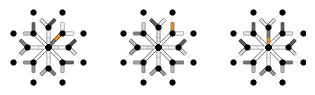

In [33]:
from matplotlib.gridspec import GridSpec
%matplotlib inline

num_cols = 3
figsize = (3.6*num_cols*cm, 2.5*cm)
fig = plt.figure(figsize=figsize)


dimer_width = 2
dw_eps = 0.5
l_width = 0.1
ncolor = 'black'
nsize = 10
ccolor = 'darkorange'


k = 1
for (cond_loc, state) in [('3NE', 2), ('3NE', 1), ('8', 5)]:
    if cond_loc == '3NE':
        cond8 = False
        cond3 = True
    elif cond_loc == '8':
        cond8 = True
        cond3 = False

    CGfilter_corrr = create_sample_filter(cond_loc)
    freqs_filtered_all = filter_all_vertices(
        state, CGfilter_corrr, cond8=cond8,
        vertices=['3E', '3SE', '3S', '3SW', '3W', '3NW', '3N', '3NE'])

    ax = fig.add_subplot(1, num_cols, k)
    ax.margins(0.015, 0.015)
    construct_correlation_graph(freqs_filtered_all, cond8=cond8,
                                ax=ax,
                                dimer_width=dimer_width,
                                dw_eps=dw_eps,
                                l_width=l_width,
                                ncolor=ncolor,
                                nsize=nsize,
                                ccolor=ccolor, cpermute=5)
    k += 1

#plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.savefig('sigma2_correlations_all.pdf', dpi=300, bbox_inches='tight')


### Old figures

In [1790]:
vertex_type_ = '8'

edge_densities = coarse_grainers[scale]['8'][case_dict[scale]
                                             [vertex_type_]['V_index']]  # filters[-1]
V_edgelist = cGV_edges[case_dict[scale][vertex_type_]['case_no']]

R = nx.Graph()
elist = [(edges[e_ind, 0], edges[e_ind, 1], {
    'colors': edge_densities[num, :]}) for num, e_ind in enumerate(V_edgelist)]
R.add_edges_from(elist)

num_vtx = np.shape(nodes)[0]
ndict = {nodes[i]: {'pos': (nodepos[i, 0], nodepos[i, 1])}
         for i in range(num_vtx)}
nx.set_node_attributes(R, ndict)

ecolors = [R[u][v]['colors'] for u, v in R.edges()]
pos_V = nx.get_node_attributes(R, 'pos')


[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
[10705] 10705
Case: 49, shape Vs:  (50000, 88, 1)
debugging {'0000': 0.0, '0001': 0.0, '0010': 0.00016758840288252054, '0011': 0.1452991452991453, '0100': 0.00016758840288252054, '0101': 0.0, '0110': 0.00016758840288252054, '0111': 0.0, '1000': 0.0, '1001': 0.13088654265124852, '1010': 0.0, '1011': 0.722473604826546, '1100': 0.0003351768057650411, '1101': 0.0005027652086475615, '1110': 0.0, '1111': 0.0}
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
will now remove 01 with frequency 0.02164
{'00': 0.4257, '10': 0.11448, '11': 0.43818}
['00', '11', '10']
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
[10705] 10705
Case: 50, shape Vs:  (50000, 67, 1)
will now remove 00 with frequency 0.04728
{'01': 0.41458, '10': 0.4188, '11': 0.11934}
['01', '11', '10']
[797, 793, 7438]
[0.3535535 0.3535535]
[1.207107 0.707107]
[0.707107 1.207107]
[7

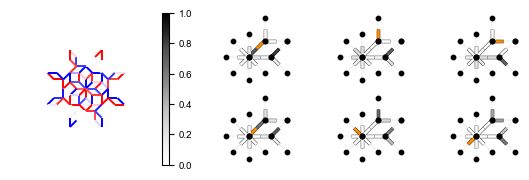

In [1917]:
%matplotlib inline
from matplotlib.gridspec import GridSpec

figsize = (18.3*cm, 5*cm)
fig = plt.figure(figsize=figsize)

num_columns = 5
gs = GridSpec(2, num_columns)  # 2 rows, n columns


dimer_width = 2
dw_eps = 0.5
l_width = 0.1
ncolor = 'black'
nsize = 10
ccolor = 'darkorange'


k = 2
for (cond_loc, state) in [('3NE', 3), ('3NE', 2), ('3NE', 1)]:
    cond8 = False

    CGfilter_corrr = create_sample_filter(cond_loc)
    freqs_filtered_all = filter_all_vertices(state, CGfilter_corrr, cond8=cond8)

    ax = fig.add_subplot(gs[0, k])
    construct_correlation_graph(freqs_filtered_all, cond8=cond8, 
                                ax=ax, 
                                dimer_width=dimer_width,
                                dw_eps=dw_eps,
                                l_width=l_width,
                                ncolor=ncolor,
                                nsize=nsize,
                                ccolor=ccolor)
    k += 1



k = 2
for (cond_loc, state) in [('8', 2), ('8', 4), ('8', 6)]:
    cond8 = True

    CGfilter_corrr = create_sample_filter(cond_loc)
    freqs_filtered_all = filter_all_vertices(state, CGfilter_corrr, cond8=cond8)

    ax = fig.add_subplot(gs[1, k])
    construct_correlation_graph(freqs_filtered_all, cond8=cond8,
                                ax=ax, 
                                dimer_width=dimer_width,
                                dw_eps=dw_eps,
                                l_width=l_width,
                                ncolor=ncolor,
                                nsize=nsize,
                                ccolor=ccolor)
    k += 1

fid = 1
ax = fig.add_subplot(gs[:, 0:2])
ax.set_aspect('equal')
ax.margins(0.4, 0.4)
a = np.array([[0, 1]])
im = plt.imshow(a, cmap="Greys")
plt.gca().set_visible(False)

fig.colorbar(im, ax=fig.get_axes()[6])




fid = 1
ax = fig.add_subplot(gs[:, 0:2])
ax.set_aspect('equal')
ax.margins(0.4, 0.4)
nx.draw(R, pos_V, node_color='black',
        node_size=0,
        edge_color=-np.array(ecolors)[:, fid],
        edge_cmap=plt.get_cmap('bwr'),
        width=0.7*dimer_width,
        edge_vmin=-np.max(edge_densities[: fid]),
        edge_vmax=np.max(edge_densities[: fid]))



plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('sigma2_correlations.pdf', dpi=300, bbox_inches='tight')


In [1273]:
coarse_grainers

{'sigma2': {'8': {389: array([[ 9.5985448e-01,  8.9009720e-01, -8.9365798e-01,  2.5170854e-01],
          [-1.2315978e+00,  1.6887152e+00,  4.5657003e-01, -1.6812177e+00],
          [ 9.9630547e-01, -9.5967269e-01, -2.9891673e-01,  9.9298185e-01],
          [-1.3803282e+00, -1.7091414e+00,  1.6938057e+00,  1.6428331e-01],
          [ 1.1317390e-02,  1.3779151e+00, -9.2866158e-01, -1.0129631e+00],
          [-2.7623983e-02, -1.3846128e+00,  8.5658318e-01,  1.0041704e+00],
          [ 1.1614647e-02, -1.3384666e+00,  8.6834842e-01,  9.0378016e-01],
          [ 2.8790426e-03,  1.3506365e+00, -7.8544253e-01, -8.5758418e-01],
          [ 1.0149660e+00, -1.4719964e+00, -2.4318410e-02,  1.6151508e+00],
          [ 1.0722574e+00,  1.5853426e+00, -1.5354627e+00, -1.1834076e-01],
          [ 9.9049681e-01, -3.0850992e-01, -9.8241717e-01,  9.6800607e-01],
          [ 3.0126318e-01, -1.0095576e+00,  8.2897967e-01,  1.0184883e+00],
          [-1.6302452e+00,  1.3573998e-02,  1.7040411e+00, -1.350856

# Pickle the trained coarse grainers

In [ ]:
coarse_grainers


In [1274]:
with open('sigma2_coarsegrainers.pickle', 'wb') as handle:
    pickle.dump(coarse_grainers, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('sigma2_coarsegrainers.pickle', 'rb') as handle:
    b = pickle.load(handle)

b


{'sigma2': {'8': {389: array([[ 9.5985448e-01,  8.9009720e-01, -8.9365798e-01,  2.5170854e-01],
          [-1.2315978e+00,  1.6887152e+00,  4.5657003e-01, -1.6812177e+00],
          [ 9.9630547e-01, -9.5967269e-01, -2.9891673e-01,  9.9298185e-01],
          [-1.3803282e+00, -1.7091414e+00,  1.6938057e+00,  1.6428331e-01],
          [ 1.1317390e-02,  1.3779151e+00, -9.2866158e-01, -1.0129631e+00],
          [-2.7623983e-02, -1.3846128e+00,  8.5658318e-01,  1.0041704e+00],
          [ 1.1614647e-02, -1.3384666e+00,  8.6834842e-01,  9.0378016e-01],
          [ 2.8790426e-03,  1.3506365e+00, -7.8544253e-01, -8.5758418e-01],
          [ 1.0149660e+00, -1.4719964e+00, -2.4318410e-02,  1.6151508e+00],
          [ 1.0722574e+00,  1.5853426e+00, -1.5354627e+00, -1.1834076e-01],
          [ 9.9049681e-01, -3.0850992e-01, -9.8241717e-01,  9.6800607e-01],
          [ 3.0126318e-01, -1.0095576e+00,  8.2897967e-01,  1.0184883e+00],
          [-1.6302452e+00,  1.3573998e-02,  1.7040411e+00, -1.350856